# <font style = "color:rgb(50,120,229)">Warping a Triangle </font>

# <font style = "color:rgb(50,120,229)">Linear vs Nonlinear Image Warping</font>

In image warping, the location of pixels in the source image is modified to the desired location in the destination image. In the general case, every pixel in the source image can be transformed to an arbitrary location in the destination image. 

## <font style = "color:rgb(50,120,229)">Linear Transform ( a.k.a Affine Transform )</font>

We have seen before that an affine transform can be used for warp the image linearly. This simply means that a point $(x_i,y_i)$ in the input image, maps to a point $(x_o,y_o)$ in the output image by 

$$
\begin{align*}x_o &= a x_i + b y_i + t_x \\y_o &= c x_i + d y_i + t_y \end{align*}
$$

Where, $a,b,c,d,t_x,t_y$ are constants. You may recall, $t_x,t_y$ are x and y components of translation ( shift ) and  $a,b,c$ and $d$ encoded rotation, scale and shear.

When the affine transform is applied to the image of a square, it can be translated, scaled, rotated and sheared. In other words, we can transform any square into a parallelogram that has rotated, changed size and move from its original location in the image. Therefore, a linear transform (i.e. affine transform) is very limiting. 

## <font style = "color:rgb(50,120,229)">Nonlinear Transforms</font>

Interesting image warps are almost always nonlinear in nature. For example, the cartoon faces displayed below would never be possible with a single linear transformation to the entire image. 

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w2-m4-cartoonfaces.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w2-m4-cartoonfaces.png" width=550/></a></center>

&nbsp;
In a non-linear warp, a point $(x_i,y_i)$ in the input image, maps to a point $(x_o,y_o)$ by a non-linear mapping $M$ function.

$$
\begin{align*}x_o &= M_x( x_i, y_i) \\ y_o &= M_y(x_i, y_i)\end{align*}
$$


### <font style = "color:rgb(50,120,229)">Approximating Nonlinear Transforms using Piecewise Linear Transforms</font>

$M$ can be very complex, but usually it is smoothly changing. Non-linear warps, while interesting, can be computationally expensive because it requires you to calculate a mapping at every pixel based on some complex warping function. 

**How do we make it efficient?** 

We know in 1-D, a complex curve can be approximated by small lines. For example, we can approximate a circle by a dodecagon.

<center><a href="https://www.learnopencv.com/wp-content/uploads/2019/10/piecewise-linear-approximation.png"><img src="https://www.learnopencv.com/wp-content/uploads/2019/10/piecewise-linear-approximation.png" width=550/></a></center>

Similarly, in 2D, the warping function can be approximated by many triangles. To accomplish this, the image can be divided into non-overlapping triangles. The warping function is calculated only at the vertices of the triangles to obtain their locations in the output image. Now, we have a collection of triangles in the input image and the corresponding triangles in the output image.

<center><a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-dealunyTriangle-1.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-dealunyTriangle-1.png" width=550 /></a></center>


Recall, there is a unique affine transform that maps one triangle to any other triangle as long as the three points are not collinear ( i.e. they do not lie on a line ). So we can calculate one affine transform per input-output triangle pair and warp all pixels inside the triangle in the source image to the triangle in the destination image. This leads to huge efficiency gain without much loss in accuracy. 

In many graphics packages, warping a triangle is a standard operation that can be achieved using a single line of code. 

However, in OpenCV, we have to write our own function to achieve this task. In this section, we will learn how to warp a single triangle in a source image to a triangle in the destination image. 

# <font style = "color:rgb(50,120,229)">Warp a Triangle</font>

In this section, we will learn how to warp a single triangle in the source image to the destination image using OpenCV. The blue triangle on the left show the triangle in the source image (photographed by yours truly) that we want to warp to the destination triangle ( also shown in blue ) in the output image. 

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-warpImage.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m3-warpImage.png" width=550/></a></center>
    
&nbsp;
We know that we can use **warpAffine** to apply an affine transform to an image, but not a triangular region inside the image. To overcome this limitation we find a bounding box around the source triangle and crop the rectangular region from the source image. We then apply an affine transform to the cropped image to obtain the output image. The previous step is crucial because it allows us to apply the affine transform to a small region of the image, thus improving computational performance. Finally, we create a triangular mask by filling pixels inside the output triangle with white. This mask when multiplied with the output image turns all pixels outside the triangle black while preserving the color of all pixels inside the triangle.

## <font style = "color:rgb(50,120,229)">Warp Triangle Code & Tutorial</font>

Without further ado, let’s dive into the code. 

In [1]:
#include "includeLibraries.h"
#include <opencv2/opencv.hpp>
#include "matplotlibcpp.h"
#include "displayImages.h"

In [2]:
using namespace std;

In [3]:
using namespace cv;

In [4]:
using namespace matplotlibcpp;

The function `warpTriangle` takes in two images, `img1` and `img2`, and two triangles, `tri1` and `tri2` as arguments. The two triangles are defined as a vector of three points. 

`img1` is the input image and `tri1` is the input triangle. 

`img2` is the output image and `tri2` is the output triangle.

Typically, the input and output triangles represent a small region of the input and output images. So we find a bounding box around the triangles and crop out that small region. This makes the code efficient. 

In [5]:
// Warps and alpha blends triangular regions from img1 and img2 to img
void warpTriangle(Mat &img1, Mat &img2, vector<Point2f> tri1, vector<Point2f> tri2)
{
  // Find bounding rectangle for each triangle
  Rect r1 = boundingRect(tri1);
  Rect r2 = boundingRect(tri2);

  // Crop the input image to the bounding box of input triangle
  Mat img1Cropped;
  img1(r1).copyTo(img1Cropped);

  // Once the bounding boxes are cropped, 
  // the triangle coordinates need to be 
  // adjusted by an offset to reflect the 
  // fact that they are now in a cropped image. 
  // Offset points by left top corner of the respective rectangles
  vector<Point2f> tri1Cropped, tri2Cropped;
  vector<Point> tri2CroppedInt;
  for(int i = 0; i < 3; i++)
  {
    tri1Cropped.push_back( Point2f( tri1[i].x - r1.x, tri1[i].y -  r1.y) );
    tri2Cropped.push_back( Point2f( tri2[i].x - r2.x, tri2[i].y - r2.y) );

    // fillConvexPoly needs a vector of Point and not Point2f
    tri2CroppedInt.push_back( Point((int)(tri2[i].x - r2.x), (int)(tri2[i].y - r2.y)) );

  }

  // Given a pair of triangles, find the affine transform.
  Mat warpMat = getAffineTransform( tri1Cropped, tri2Cropped );

  // Apply the Affine Transform just found to the src image
  Mat img2Cropped = Mat::zeros(r2.height, r2.width, img1Cropped.type());
  warpAffine( img1Cropped, img2Cropped, warpMat, img2Cropped.size(), INTER_LINEAR, BORDER_REFLECT_101);

  // We are interested in the pixels inside 
  // the triangle and not the entire bounding box. 

  // So we create a triangular mask using fillConvexPoly.
  // This mask has values 1 ( in all three channels ) 
  // inside the triangle and 0 outside.   
  // Get mask by filling triangle
  Mat mask = Mat::zeros(r2.height, r2.width, CV_32FC3);
  fillConvexPoly(mask, tri2CroppedInt, Scalar(1.0, 1.0, 1.0), 16, 0);

  // Copy triangular region of the rectangular patch to the output image
  multiply(img2Cropped,mask, img2Cropped);
  multiply(img2(r2), Scalar(1.0,1.0,1.0) - mask, img2(r2));
  img2(r2) = img2(r2) + img2Cropped;

}

In [6]:
// Read input image and convert to float
Mat imgIn = imread(DATA_PATH + "images/kingfisher.jpg");

In [7]:
// Convert to floating point image in the range 0 to 1.
imgIn.convertTo(imgIn, CV_32FC3, 1/255.0);

In [8]:
// Create white output image the same size and type of input image
Mat imgOut = Mat::ones(imgIn.size(), imgIn.type());
imgOut = Scalar(1.0,1.0,1.0);

Next, the input and output triangles are defined as vector of 3 points each.

Finally, call warpTriangle to calculate the output image.

In [9]:
// Input triangle
vector <Point2f> triIn;
triIn.push_back(Point2f(360,50));
triIn.push_back(Point2d(60,100));
triIn.push_back(Point2f(300,400));

// Output triangle
vector <Point2f> triOut;
triOut.push_back(Point2f(400,200));
triOut.push_back(Point2f(160,270));
triOut.push_back(Point2f(400,400));

// Warp all pixels inside input triangle to output triangle
warpTriangle(imgIn, imgOut, triIn, triOut);

For display purposes, we are drawing the input triangle on the input image and output triangle on the output image using `cv::polylines`.

**Note**:

- We need to convert the images to `CV_8U3` format before drawing the lines because pretty looking anti-aliased lines (specified using `lineType = LINE_AA`) are only supported for `CV_8U3` images.
- `cv::polylines` takes as input a vector of type `cv::Point` and not `cv::Point2f`. Hence a conversion is necessary.

In [10]:
// Draw triangle on the input and output image.

// Convert back to uint because OpenCV antialiasing
// does not work on image of type CV_32FC3

imgIn.convertTo(imgIn, CV_8UC3, 255.0);
imgOut.convertTo(imgOut, CV_8UC3, 255.0);

// Draw triangle using this color
Scalar color = Scalar(255, 150, 0);

// cv::polylines needs vector of type Point and not Point2f
vector <Point> triInInt, triOutInt;
for(int i=0; i < 3; i++)
{
    triInInt.push_back(Point(triIn[i].x,triIn[i].y));
    triOutInt.push_back(Point(triOut[i].x,triOut[i].y));
}

In [11]:
// Draw triangles in input and output images
int lineWidth = 2;
polylines(imgIn, triInInt, true, color, lineWidth, LINE_AA);
polylines(imgOut, triOutInt, true, color, lineWidth, LINE_AA);

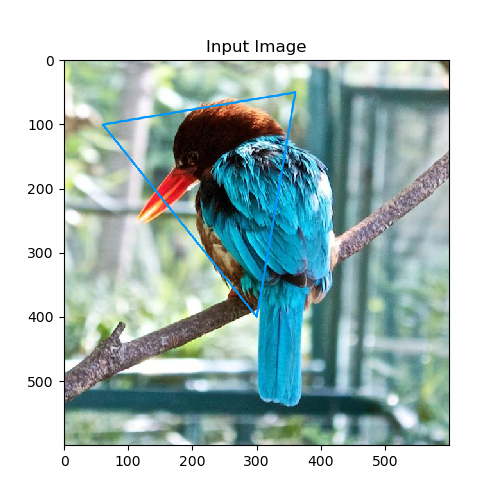

In [12]:
// Display and save input and output images.
plt::figure_size(500,500);
plt::imshow(imgIn);
plt::title("Input Image");
auto pltImg = displayImage(imgIn);
pltImg

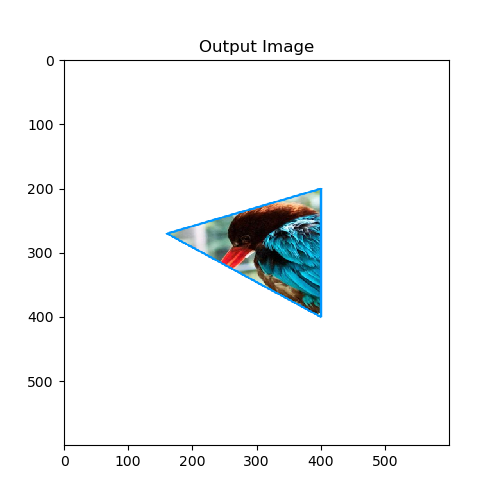

In [13]:
plt::figure_size(500,500);
plt::imshow(imgOut);
plt::title("Output Image");
pltImg = displayImage(imgOut);
pltImg